In [1]:
#import libraries 
import gym
from env.custom_hopper import *
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

import numpy as np
import matplotlib.pyplot as plt


/home/federica/anaconda3/envs/mldl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import env
env = gym.make('CustomHopper-source-v0')

In [3]:
#print all body names of the en
print(env.sim.model.body_names)

('world', 'torso', 'thigh', 'leg', 'foot')


1. world
    - serves as a reference frame for the entire simulation. It is the origin point from which all other bodies' positions and orientations are measured
    - not a physical object
    -  Other bodies are positioned and oriented relative to the 'world' body
2. Torso
    - serves as the main mass of the robot and contains the core components. The torso is responsible for maintaining the robot's **balance** and overall **stability** during movement.
    - NOTE: we do **not** want to randomize the torso mass!
3. Thigh
     - plays a crucial role in the **locomotion** of the robot.
     - The thigh moves to create the primary **force needed for hopping or walking.**
     - changing mass impacts: the heavier is the mass, the higher is the force and the energy needed to move
4. Leg 
    - contributes to extending and retracting movements necessary for jumping and landing.
    - changing mass impacts: it influences how effectively force is transferred from thigh to foot
        - Heavier legs might better absorb impacts but could also slow down rapid movements.
5. Foot
    - provides stability and traction during locomotion.
    - changing mass impacts: how the robot lands on the ground and how it lifts

We want to work on the link masses of the Hopper robot, that is: thigh, leg, foot.  Specifically, we want to design a  uniform distribution over these masses in the source environment. \\
Keep in mind that the in the source env torso_mass_env = torso_mass -1 

In [4]:
#Default values for the masses
print(f"default mass of the torso:{env.sim.model.body_mass[1]} \ndefault mass of the thigh:{env.sim.model.body_mass[2]} \ndefault mass of the leg:{env.sim.model.body_mass[3]} \ndefault mass of the foot :{env.sim.model.body_mass[4]}")

default mass of the torso:2.534291735288517 
default mass of the thigh:3.9269908169872427 
default mass of the leg:2.7143360527015816 
default mass of the foot :5.0893800988154645


Let us try to use this configuration:
- we keep the default value for the torso's mass in the target env
- set the length of the mass interval on
    - 1 kg for  thigh and leg
    - 0.5 kg for the foot
        - reasoning: a light foot provides more agility, but we do not want the weight to vary drastically for the sake of stability

In [5]:
# Define mass bounds for randomization
mass_bounds = {
    'thigh': {'low': 3.5, 'high': 4.5},  
    'leg': {'low': 2.25, 'high': 3.25},    
    'foot': {'low': 4.75, 'high': 5.25}    
}

# Define the fixed torso mass relative to the target environment
target_torso_mass = env.sim.model.body_mass[1] 
source_torso_mass = target_torso_mass - 1.0


Let us customize the source environment by accessing the MuJoCo model directly. \\
These changes will only affect the execution of that file, since each environment instance in Gym operates independently. Other files or subsequent executions of other files will not be affected by these changes unless they also modify the MuJoCo model themselves.

**NOTE**: If you want to persist modifications to the MuJoCo model across multiple executions or instances, you would need to save the modified parameters and apply them when creating new environment instances.

In [6]:
#Define a custom environment wrapper that randomizes the parameters each time the environment is reset.
class CustomHopperEnvWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomHopperEnvWrapper, self).__init__(env)
        self.env = env
        #Access the Mujoco model
        self.model = env.unwrapped.sim.model

    def reset(self, **kwargs):
        # Randomize masses for thigh, leg, and foot
        thigh_mass = np.random.uniform(mass_bounds['thigh']['low'], mass_bounds['thigh']['high'])
        leg_mass = np.random.uniform(mass_bounds['leg']['low'], mass_bounds['leg']['high'])
        foot_mass = np.random.uniform(mass_bounds['foot']['low'], mass_bounds['foot']['high'])

        # Set the masses in the environment
        self.model.body_mass[2] = thigh_mass       # Thigh mass
        self.model.body_mass[3] = leg_mass         # Leg mass
        self.model.body_mass[4] = foot_mass        # Foot mass
        self.model.body_mass[1] = source_torso_mass  # Torso mass

        return self.env.reset(**kwargs)

In [7]:
# Define a function to create a new instance of the environment
def make_env(env_id, rank, seed=0):
    def _init():
        env = gym.make(env_id)
        env = Monitor(env)  # Add the Monitor wrapper to log episode rewards
        env.seed(seed + rank)
        return CustomHopperEnvWrapper(env)
    return _init

# Custom callback to log rewards at the end of each episode during training. It saves the rewards to a NumPy file at the end of training.
#It allows us to track and later visualize how the agent's performance improves over time.
class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
        if self.locals['dones'][0]:
            # Ensure the 'episode' key is in the info dictionary
            if 'episode' in self.locals['infos'][0]:
                self.episode_rewards.append(self.locals['infos'][0]['episode']['r'])
        return True

    def _on_training_end(self) -> None:
        np.save("episode_rewards.npy", self.episode_rewards)


# Create a list of env_fns, each being a callable that returns a new environment instance
n_envs = 4
env_id = 'CustomHopper-source-v0'
seed = 0
env_fns = [make_env(env_id, i, seed) for i in range(n_envs)]

# Create the vectorized environment using make_vec_env
source_vec_env = DummyVecEnv(env_fns)


# Create the PPO model
model = PPO("MlpPolicy", source_vec_env, verbose=0)

# Train the model with the reward callback
reward_callback = RewardCallback()
model.learn(total_timesteps=1000000, callback=reward_callback)


# Evaluate the policy in the source environment
mean_reward, std_reward = evaluate_policy(model, source_vec_env, n_eval_episodes=10)
print(f"Mean reward in source environment: {mean_reward} +/- {std_reward}")


KeyboardInterrupt: 

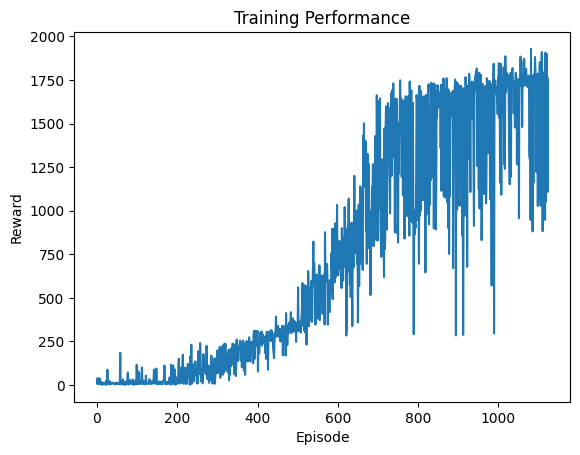

In [ ]:
# Load and plot the rewards
episode_rewards = np.load("episode_rewards.npy")
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Performance')
plt.show()

In [ ]:
#save the trained model
model.save("task6_trained_model.zip")


In [ ]:
# Load the trained model
trained_model = PPO.load("task6_trained_model.zip")

# Create environments for source and target environments
source_env = gym.make('CustomHopper-source-v0')
target_env = gym.make('CustomHopper-target-v0')

# Evaluate the trained policy on the source environment
mean_reward_source, std_reward_source = evaluate_policy(trained_model, source_env, n_eval_episodes=10)
print(f"Mean reward on source environment: {mean_reward_source} +/- {std_reward_source}")

# Evaluate the trained policy on the target environment
mean_reward_target, std_reward_target = evaluate_policy(trained_model, target_env, n_eval_episodes=10)
print(f"Mean reward on target environment: {mean_reward_target} +/- {std_reward_target}")

/home/federica/anaconda3/envs/mldl/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:71: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Mean reward on source environment: 809.4336805343628 +/- 28.601903803264932
Mean reward on target environment: 517.8027674913407 +/- 6.244498669404591
